# Welcome to simple RL (AI) T-Rex (Chrome Dino) projects
###### Autors: MK & MP

In [1]:
# Uncomment this line to install proper package if not installed
# !pip3 install selenium
# !pip3 install --upgrade pip
# !pip3 install --upgrade setuptools
# !pip install line_profiler
# !pip install mss
# !pip install opencv-python
# !pip install numpy
# !pip install matplotlib
# !pip install image

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import os
import time
import random
import json
import IPython
import PIL
import cv2
from PIL import Image
from mss.darwin import MSS as mss
import mss.tools
import numpy as np

In [3]:
roi = {
    "top": 0, 
    "left": 0, 
    "width": 500, 
    "height": 300,
    'top_i': 100,
    'left_i': 20,
    'width_i': -30,
    'height_i': -120
}

In [4]:
def run_dino_game(CHROMEDRIVER_PATH):
    # You must install CHROMEDRIVER from https://chromedriver.storage.googleapis.com/index.html?path=73.0.3683.68/
    # Then you must unzip proper verison on set path to it below
    # For now I deliver chromedriver for chrome 73 near to this file
    
    CHROMEDRIVER_PATH = CHROMEDRIVER_PATH
    
    # Check path to chromedriver
    if CHROMEDRIVER_PATH is None:
        print("Set path to CHROMEDRIVER!!!!")
        raise KeyboardInterrupt
    elif not os.path.isfile(CHROMEDRIVER_PATH):
        print("I do not see file under the path!!!")
        raise KeyboardInterrupt
    
    # Initialize chromedriver
    options = Options()
#     options.add_argument("--headless") # Runs Chrome in headless mode. (No window show)
    options.add_argument('--no-sandbox') # Bypass OS security model
    options.add_argument('--hide-scrollbars')
    options.add_argument('disable-infobars')
    options.add_argument('--disable-gpu')
    options.add_argument('--disable-extensions')
    options.add_argument('--window-position={},{}'.format(roi['top'],roi['left']))
    options.add_argument('--window-size={},{}'.format(roi['width'],roi['height']))
    options.add_argument('--no-proxy-server')
    driver = webdriver.Chrome(options=options, executable_path=CHROMEDRIVER_PATH)
    # go to proper URL adress for game
    driver.get("chrome://dino")
    return driver

In [5]:
# https://godoc.org/github.com/unixpickle/muniverse/chrome
def dispatch_key_event(driver, name, options = {}):
    options["type"] = name
    body = json.dumps({'cmd': 'Input.dispatchKeyEvent', 'params': options})
    resource = "/session/%s/chromium/send_command" % driver.session_id
    url = driver.command_executor._url + resource
    driver.command_executor._request('POST', url, body)

In [6]:
def press_key_up(driver):
    options = { \
    "code": "ArrowUp",
    "key": "ArrowUp",
    "text": "",
    "unmodifiedText": "",
    "nativeVirtualKeyCode": 38,
    "windowsVirtualKeyCode": 38
    }
    dispatch_key_event(driver, "rawKeyDown", options)
    dispatch_key_event(driver, "char", options)
    dispatch_key_event(driver, "keyUp", options)

In [7]:
def hold_key_down(driver):
    options = { \
    "code": "ArrowDown",
    "key": "ArrowDown",
    "text": "",
    "unmodifiedText": "",
    "nativeVirtualKeyCode": 40,
    "windowsVirtualKeyCode": 40
    }
    dispatch_key_event(driver, "rawKeyDown", options)
    dispatch_key_event(driver, "char", options)

In [8]:
def release_key(driver):
    options_up = { \
    "code": "ArrowUp",
    "key": "ArrowUp",
    "text": "",
    "unmodifiedText": "",
    "nativeVirtualKeyCode": 38,
    "windowsVirtualKeyCode": 38
    }
    options_down = { \
    "code": "ArrowDown",
    "key": "ArrowDown",
    "text": "",
    "unmodifiedText": "",
    "nativeVirtualKeyCode": 40,
    "windowsVirtualKeyCode": 40
    }
    dispatch_key_event(driver, "keyUp", options_up)
    dispatch_key_event(driver, "keyUp", options_down)

In [9]:
def do_action(driver, action):
    if action == 'n':
        release_key(driver)
    if action == 'r':
        release_key(driver)
        driver.execute_script('Runner().restart()')
    if action == 'j':
        release_key(driver)
        press_key_up(driver)
    if action == 'd':
        hold_key_down(driver)

In [10]:
last_frame_to_fps = 10
last_frame_idx = 0
list_to_calc_fps = [1]*last_frame_to_fps

def print_info_about_game(last_trex_status,game_data,last_time):
    global last_frame_idx
    global list_to_calc_fps
    
    last_frame_idx += 1
    if last_frame_idx == last_frame_to_fps:
        last_frame_idx = 0
    list_to_calc_fps[last_frame_idx] = time.time() - last_time
    
    avg_fps = (1/np.mean(list_to_calc_fps))
    
    if game_data['tRex_status'] != last_trex_status:
        print('{:10.2f} fps:{:3.1f} {}'.format(game_data['runningTime'],avg_fps,game_data['tRex_status']))
        last_trex_status = game_data['tRex_status']
    return last_trex_status

In [17]:
kernel = np.ones((5,5),np.uint8)
thresh_white = 200
thresh_black = 90
thresh_area = 400
def img_process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mean_color = np.mean(img)
    if mean_color < thresh_white:
        img = cv2.threshold(img, thresh_black, 255, cv2.THRESH_BINARY)[1]
    else:
        img = cv2.threshold(img, thresh_white, 255, cv2.THRESH_BINARY)[1]
        img = ~img
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    img = cv2.dilate(img,kernel,iterations = 1)
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    new_img = np.zeros_like(img)
    for cnt in contours:
        if cv2.contourArea(cnt) > thresh_area:
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255),-1)
    return new_img

In [18]:
tmp_image = None
def get_game_info(driver):
    global tmp_image
    runner = driver.execute_script("""return {
                                   crashed: Runner().crashed,
                                   playCount: Runner().playCount,
                                   tRex_status: Runner().tRex.status,
                                   runningTime: Runner().runningTime,
                                   obstacles: Runner().horizon.obstacles
                                   }""")

    to_return =  {
        'crashed':runner['crashed'],
        'runningTime':runner['runningTime'],
        'playCount':runner['playCount'],
        'tRex_status':runner['tRex_status'],
        'obstacles': []
    }
    
    for idx,ob in enumerate(runner['obstacles']):
        to_return['obstacles'].append({
            'type':ob['typeConfig']['type'],
            'xPos':ob['xPos'],
            'yPos':150 - ob['yPos'],
            'width':ob['width']
        })

    with mss.mss() as sct:
        res = driver.get_window_rect()
        monit = {
            "top": res['y']+roi['top_i'], 
            "left": res['x']+roi['left_i'], 
            "width": res['width']+roi['width_i'], 
            "height": res['height']+roi['height_i']
        }
        sct_img = sct.grab(monit)
        tmp_image = np.array(sct_img)
        to_return['screen'] = img_process(np.array(sct_img))
    return to_return

In [19]:
def get_last_seconds(game_data_list,game_data,milisec=1000):
    game_data_list.append(game_data)
    actual_time = game_data['runningTime']
    while actual_time - game_data_list[0]['runningTime'] > milisec:
        game_data_list.pop(0)
    return game_data_list

In [20]:
def check_min_max_game_data_list(game_data_list):
    mn = 999999999999
    mx = 0
    for x in game_data_list:
        if x['runningTime'] > mx:
            mx = x['runningTime']
        if x['runningTime'] < mn:
            mn = x['runningTime']
    return mn,mx

In [22]:
def main_loop(driver,show_images):
    last_trex_status = None
    last_time = time.time()
    frame_iter = 0
    game_data_list = []
    while True:
        game_data = get_game_info(driver)
        game_data_list = get_last_seconds(game_data_list,game_data,milisec=1000)
        frame_iter += 1
        mn,mx = check_min_max_game_data_list(game_data_list)
        print("game_data_list len:",len(game_data_list),mn,mx)
        last_trex_status = print_info_about_game(last_trex_status,game_data,last_time)
        last_time = time.time()
        
        if game_data['tRex_status'] == 'WAITING':
            # Here tRex wait for start
            do_action(driver,'j')

        if ((show_images) and (frame_iter % 100 == 0)):
            IPython.display.display(PIL.Image.fromarray(game_data['screen']))

        if game_data['tRex_status'] in ['RUNNING','DUCKING','JUMPING']:
            rr = random.randint(0,100)
            if rr < 15:
                do_action(driver,'j')
            elif rr < 80:
                do_action(driver,'d')
            else:
                do_action(driver,'n')

        # end process when dino died :(
        if game_data['crashed']:
            time.sleep(0.3)
            print("You died!!!!")
            # Here game_data_list is cleaning
            game_data_list = []
            do_action(driver,'r') 
#             break


In [23]:
def main():
    try:
        driver = run_dino_game(CHROMEDRIVER_PATH='./chromedriver')
        time.sleep(1.0)
        show_images = True
        main_loop(driver,show_images)
    finally:
        driver.quit()

game_data_list len: 1 0 0
      0.00 fps:1.1 WAITING
game_data_list len: 2 0 47.95999999623746
     47.96 fps:1.2 JUMPING
game_data_list len: 3 0 82.74499999242835
game_data_list len: 4 0 116.60499998833984
game_data_list len: 5 0 133.60000000102445
game_data_list len: 6 0 168.13499998534098
game_data_list len: 7 0 201.50500000454485
    201.51 fps:3.1 DUCKING
game_data_list len: 8 0 250.18000000272878
    250.18 fps:4.3 RUNNING
game_data_list len: 9 0 283.5299999860581
    283.53 fps:7.5 DUCKING
game_data_list len: 10 0 318.425000004936
    318.43 fps:27.3 RUNNING
game_data_list len: 11 0 352.8050000022631
    352.81 fps:26.5 JUMPING
game_data_list len: 12 0 383.8699999905657
game_data_list len: 13 0 416.3399999961257
game_data_list len: 14 0 449.5949999836739
game_data_list len: 15 0 501.04999999166466
    501.05 fps:27.9 DUCKING
game_data_list len: 16 0 533.6099999840371
game_data_list len: 17 0 567.2349999949802
game_data_list len: 18 0 567.2349999949802
     18.27 fps:28.3 JUMPING

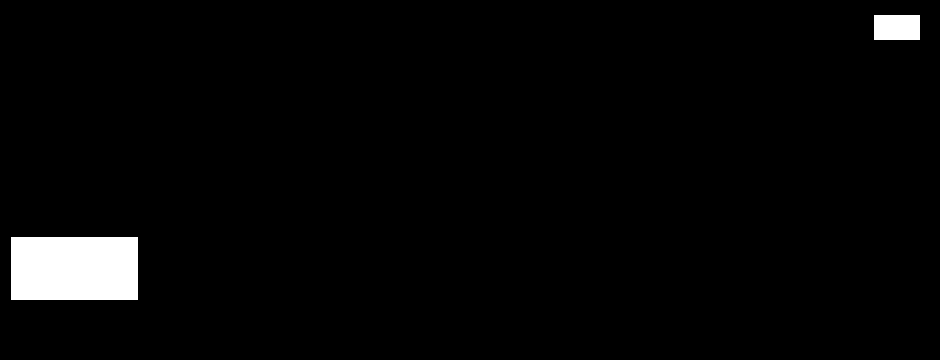

game_data_list len: 27 2067.23499999498 3051.979999989271
game_data_list len: 26 2134.920000011334 3102.8649999934714
game_data_list len: 26 2169.2000000039116 3134.939999989001
   3134.94 fps:25.1 RUNNING
game_data_list len: 27 2169.2000000039116 3168.0899999919347
   3168.09 fps:25.6 DUCKING
game_data_list len: 27 2234.82499999227 3202.4899999960326
   3202.49 fps:26.1 RUNNING
game_data_list len: 28 2234.82499999227 3234.6050000051036
   3234.61 fps:26.6 DUCKING
game_data_list len: 28 2285.3549999999814 3268.0399999953806
game_data_list len: 28 2350.815000012517 3303.3749999885913
   3303.37 fps:25.1 RUNNING
game_data_list len: 28 2367.37500000163 3351.8650000041816
   3351.87 fps:24.9 DUCKING
game_data_list len: 28 2417.76499999105 3369.845000008354
game_data_list len: 28 2467.4750000122003 3420.559999998659
game_data_list len: 29 2467.4750000122003 3451.5149999933783
game_data_list len: 28 2518.624999996973 3485.5500000121538
game_data_list len: 29 2518.624999996973 3518.3400000096

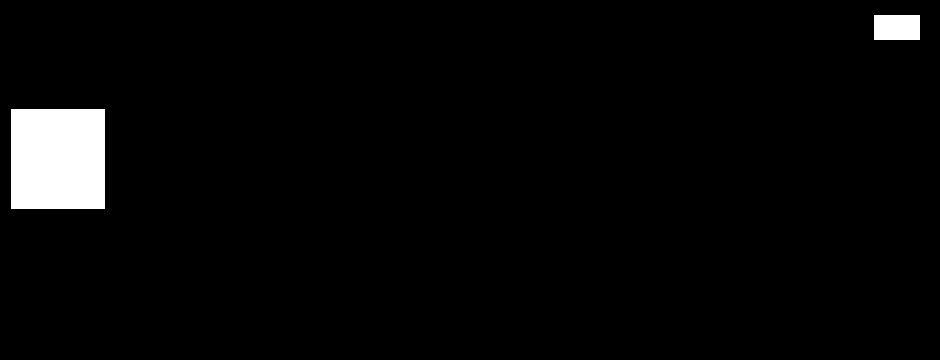

game_data_list len: 17 1481.48499999661 2449.575000006007
   2449.58 fps:12.4 DUCKING
game_data_list len: 15 1564.7999999928288 2532.474999985425
   2532.47 fps:11.9 RUNNING
game_data_list len: 15 1615.1050000044052 2598.709999991115
   2598.71 fps:11.7 JUMPING
game_data_list len: 13 1698.4550000051968 2683.965000003809
game_data_list len: 12 1831.8750000034925 2765.429999999469
game_data_list len: 12 1932.7399999892805 2865.5699999944773
   2865.57 fps:11.4 RUNNING
game_data_list len: 12 1998.8000000012107 2966.645000007702
game_data_list len: 12 2065.889999998035 3049.174999992829
   3049.17 fps:11.1 DUCKING
game_data_list len: 12 2149.3049999990035 3149.104999989504
game_data_list len: 12 2249.355000007199 3215.989999996964
   3215.99 fps:11.4 RUNNING
game_data_list len: 12 2332.399999984773 3298.8900000054855
   3298.89 fps:11.7 DUCKING
game_data_list len: 12 2449.575000006007 3382.45000000461
   3382.45 fps:11.5 RUNNING
game_data_list len: 12 2532.474999985425 3484.5299999869894
 

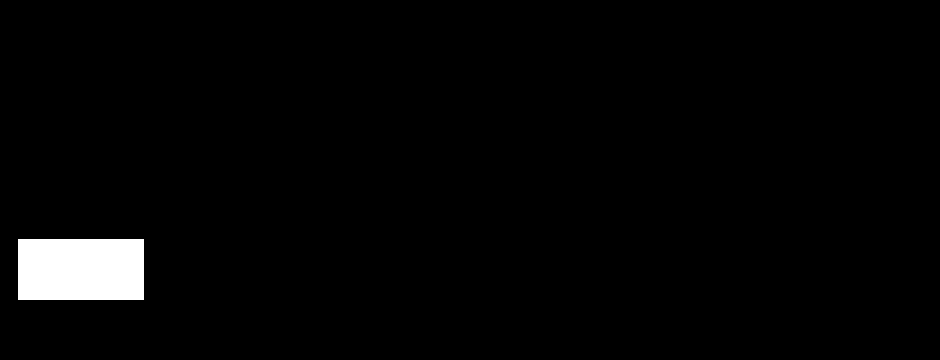

game_data_list len: 19 0.41000000783242285 794.8050000122748
game_data_list len: 20 0.41000000783242285 828.4900000144262
game_data_list len: 21 0.41000000783242285 878.1500000040978
game_data_list len: 22 0.41000000783242285 945.4799999948591
    945.48 fps:18.9 RUNNING
game_data_list len: 23 0.41000000783242285 994.5799999986775
    994.58 fps:21.6 DUCKING
game_data_list len: 23 28.40999999898486 1012.0549999992363
game_data_list len: 22 79.25000000977889 1062.0800000033341
game_data_list len: 22 111.17499999818392 1095.2699999907054
   1095.27 fps:23.8 RUNNING
game_data_list len: 22 160.5649999983143 1128.2550000178162
   1128.26 fps:24.7 JUMPING
game_data_list len: 22 177.46000000624917 1161.08499999973
game_data_list len: 21 260.89500001398847 1212.3049999936484
game_data_list len: 22 260.89500001398847 1228.8950000074692
game_data_list len: 22 294.17500001727603 1262.0199999946635
game_data_list len: 22 343.8599999935832 1295.8100000105333
game_data_list len: 23 343.8599999935832

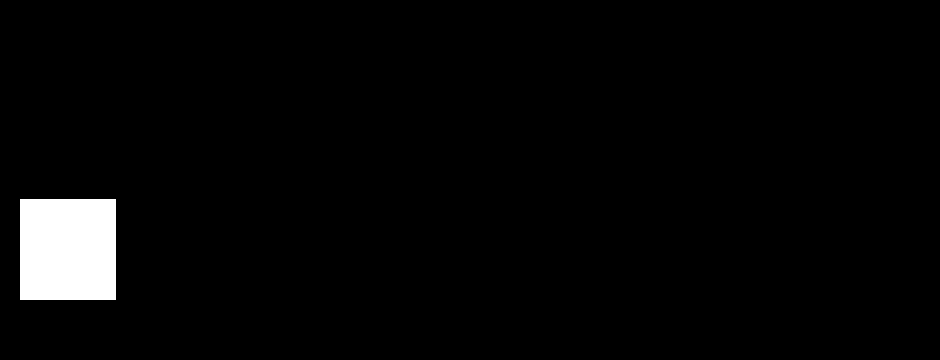

game_data_list len: 29 157.70000001066364 1125.6449999928009
   1125.64 fps:30.3 RUNNING
game_data_list len: 29 174.47500000707805 1159.6150000113994
   1159.62 fps:29.5 DUCKING
game_data_list len: 29 208.95000000018626 1192.9450000170618
game_data_list len: 29 241.4850000059232 1209.0000000025611
game_data_list len: 29 292.1550000028219 1242.805000016233
game_data_list len: 30 292.1550000028219 1275.7299999939278
game_data_list len: 29 357.8900000138674 1309.4250000140164
game_data_list len: 30 357.8900000138674 1341.275000013411
   1341.28 fps:29.3 RUNNING
game_data_list len: 29 441.82000000728294 1392.1200000040699
   1392.12 fps:28.7 DUCKING
game_data_list len: 30 441.82000000728294 1408.625000010943
game_data_list len: 30 491.665000008652 1458.165000018198
   1458.17 fps:28.0 JUMPING
game_data_list len: 29 558.4749999979977 1525.6850000005215
game_data_list len: 29 591.0100000037346 1558.485000015935
game_data_list len: 29 607.8550000092946 1592.0749999932013
game_data_list len: 2

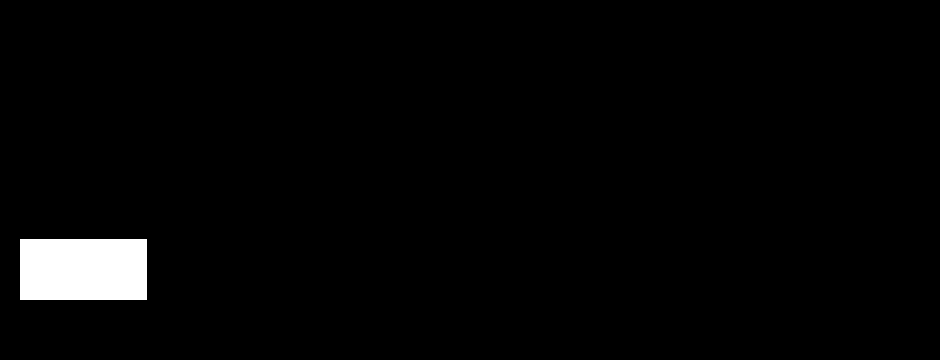

game_data_list len: 20 1166.495000012219 2083.104999997886
game_data_list len: 21 1166.495000012219 2116.2900000053924
   2116.29 fps:21.0 DUCKING
game_data_list len: 21 1200.6650000112131 2199.6450000151526
   2199.65 fps:19.0 JUMPING
game_data_list len: 20 1317.6099999982398 2317.2450000129174
game_data_list len: 18 1433.1100000126753 2400.9749999968335
game_data_list len: 18 1549.3199999909848 2485.9700000088196
game_data_list len: 19 1549.3199999909848 2533.7599999911617
game_data_list len: 17 1634.2750000185333 2616.7849999910686
   2616.78 fps:14.8 RUNNING
game_data_list len: 16 1766.0350000078324 2717.065000004368
game_data_list len: 16 1851.040000008652 2801.035000011325
   2801.04 fps:13.0 DUCKING
game_data_list len: 17 1851.040000008652 2850.3700000001118
   2850.37 fps:12.5 RUNNING
game_data_list len: 16 1966.6399999987334 2933.9749999926426
   2933.97 fps:12.2 DUCKING
game_data_list len: 16 1983.4799999953248 2967.065000004368
game_data_list len: 16 2017.7850000036415 3000.

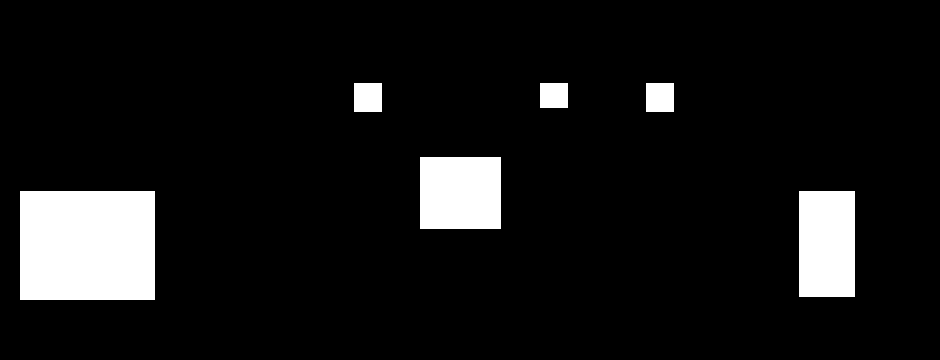

You died!!!!
game_data_list len: 1 0.4650000191759318 0.4650000191759318
      0.47 fps:11.3 RUNNING
game_data_list len: 2 0.4650000191759318 25.489999999990687
game_data_list len: 3 0.4650000191759318 75.66999999107793
     75.67 fps:12.1 JUMPING
game_data_list len: 4 0.4650000191759318 109.09499999252148
game_data_list len: 5 0.4650000191759318 159.4700000132434
    159.47 fps:11.8 RUNNING
game_data_list len: 6 0.4650000191759318 226.25000000698492
    226.25 fps:11.2 DUCKING
game_data_list len: 7 0.4650000191759318 309.8500000196509
    309.85 fps:11.4 RUNNING
game_data_list len: 8 0.4650000191759318 376.0650000185706
game_data_list len: 9 0.4650000191759318 409.1550000011921
    409.16 fps:12.5 DUCKING
game_data_list len: 10 0.4650000191759318 443.4400000027381
game_data_list len: 11 0.4650000191759318 476.90000000875443
game_data_list len: 12 0.4650000191759318 509.5300000102725
game_data_list len: 13 0.4650000191759318 542.2350000008009
    542.24 fps:21.4 RUNNING
game_data_list 

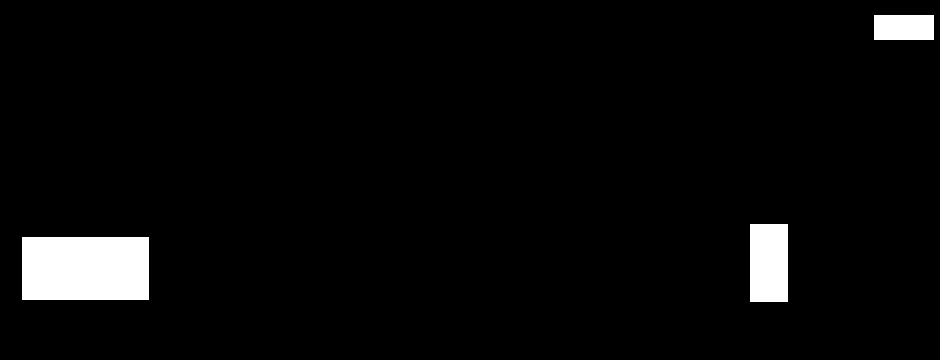

game_data_list len: 31 2426.4750000147615 3411.4300000073854
game_data_list len: 31 2477.260000014212 3448.3600000094157
game_data_list len: 31 2494.414999993751 3493.7300000165123
   3493.73 fps:28.9 RUNNING
game_data_list len: 30 2559.724999999162 3544.7449999919627
   3544.74 fps:26.8 JUMPING
game_data_list len: 29 2610.660000005737 3594.154999998864
game_data_list len: 29 2643.5700000147335 3627.9100000101607
game_data_list len: 29 2693.2600000000093 3661.6849999991246
game_data_list len: 28 2760.370000003604 3711.7600000055972
game_data_list len: 29 2760.370000003604 3743.910000019241
game_data_list len: 29 2776.819999999134 3776.7450000101235
game_data_list len: 28 2860.210000013467 3810.8850000135135
   3810.89 fps:25.2 DUCKING
game_data_list len: 29 2860.210000013467 3845.1550000172574
game_data_list len: 29 2893.9900000113994 3877.940000005765
game_data_list len: 28 2944.6049999969546 3928.8200000009965
   3928.82 fps:26.1 JUMPING
game_data_list len: 28 2994.650000007823 3961.

NoSuchWindowException: Message: no such window: window was already closed
  (Session info: chrome=73.0.3683.75)
  (Driver info: chromedriver=73.0.3683.68 (47787ec04b6e38e22703e856e101e840b65afe72),platform=Mac OS X 10.14.3 x86_64)


In [24]:
# %lprun -f get_game_info main()
main()

In [178]:
np.mean(tmp_image)

250.55818262411347

(360, 940)
(360, 940, 4)


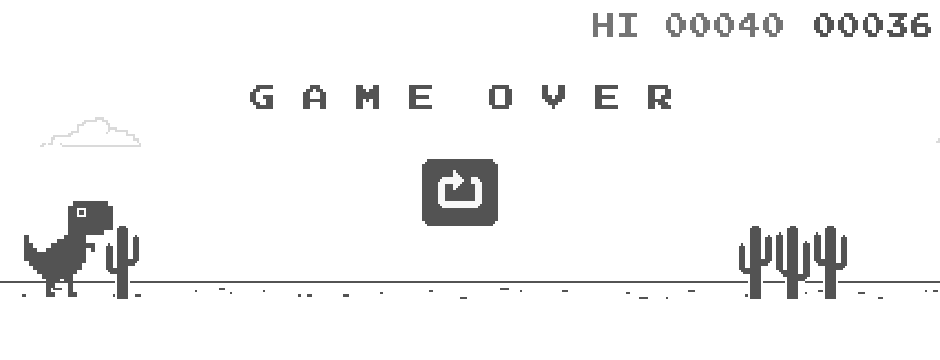

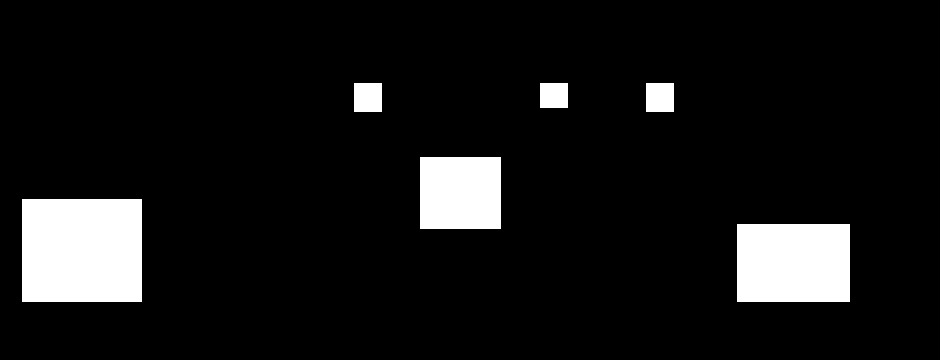

In [25]:
tmp_image_proc = img_process(tmp_image)
print(tmp_image_proc.shape)
print(tmp_image.shape)
IPython.display.display(PIL.Image.fromarray(tmp_image))
IPython.display.display(PIL.Image.fromarray(tmp_image_proc))